```
This software is part of GPU Ocean. 

Copyright (C) 2024 SINTEF Digital

Investigating in landmask erosion

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# What happens when we initialize sim by eroding the landmask?

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from netCDF4 import Dataset
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
plt.rcParams["animation.html"] = "jshtml"
mpl.rcParams['figure.facecolor'] = 'white'

from importlib import reload

In [2]:
from gpuocean.SWEsimulators import CDKLM16
from gpuocean.utils import Common, IPythonMagic, NetCDFInitialization, OceanographicUtilities


In [3]:
%cuda_context_handler gpu_ctx

### Load data and define case

In [4]:
source_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'


case_info = {'name': 'NA',  'x0': 1500, 'x1': 1750, 'y0':  475, 'y1':  675 }
print(case_info["name"])

erodes = 3
data_args0 = [None]*erodes 
data_args5 = [None]*erodes 
timestep_indices0 = [0,1,2]
timestep_indices5 = [5,6,7]
for i in range(erodes):
    data_args0[i] = NetCDFInitialization.getInitialConditions(source_url,
                                                            case_info["x0"], case_info["x1"], case_info["y0"], case_info["y1"], 
                                                            timestep_indices=timestep_indices0,
                                                            download_data=False,
                                                            erode_land=i
                                                            )
    data_args5[i] = NetCDFInitialization.getInitialConditions(source_url,
                                                            case_info["x0"], case_info["x1"], case_info["y0"], case_info["y1"], 
                                                            timestep_indices=timestep_indices5,
                                                            download_data=False,
                                                            erode_land=i
                                                            )

NA


In [5]:
def plot_state(deta, dhu, dhv):
    fig = plt.figure(figsize = (18, 3))
    data = [deta, dhu, dhv]

    max_eta = np.max(np.abs(deta))
    max_huv = max(np.max(np.abs(dhv)), np.max(np.abs(dhu)))
    max_vals = [max_eta, max_huv, max_huv]



    for i in range(3):
        ax = plt.subplot(1, 3, i+1)
        sp = ax.imshow(data[i], interpolation="none", origin="lower", cmap=plt.cm.coolwarm,
                       vmin=-max_vals[i], vmax=max_vals[i])
        plt.colorbar(sp, shrink=0.9)

def plot_state_da(da):
    plot_state(da["eta0"], da["hu0"], da["hv0"])


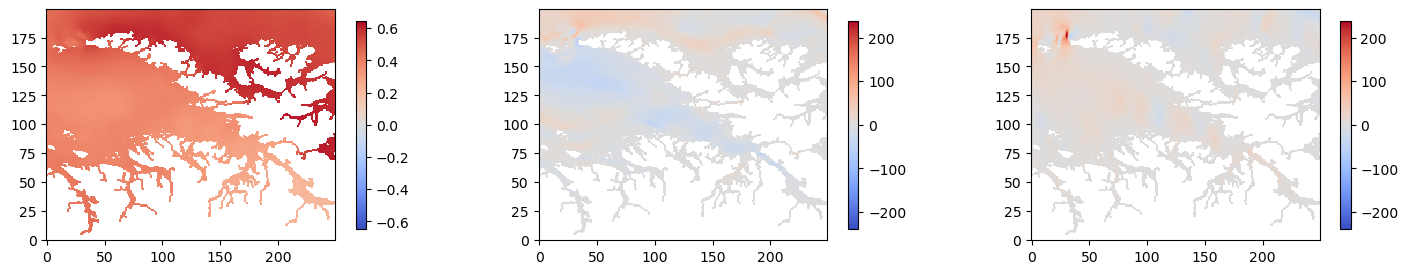

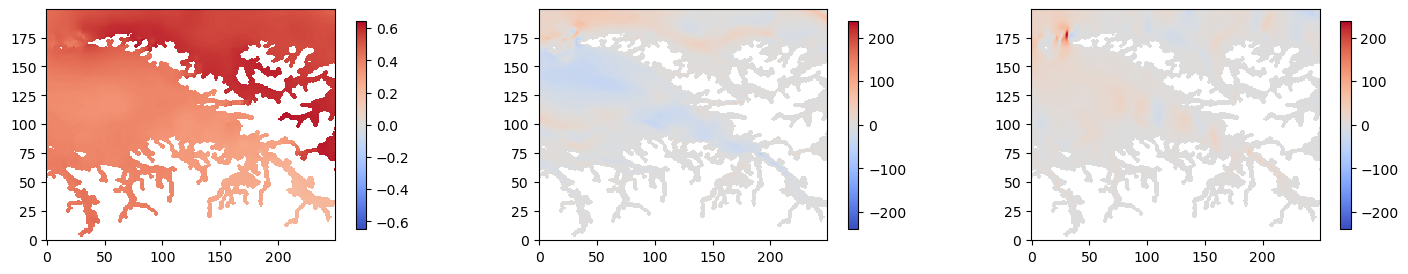

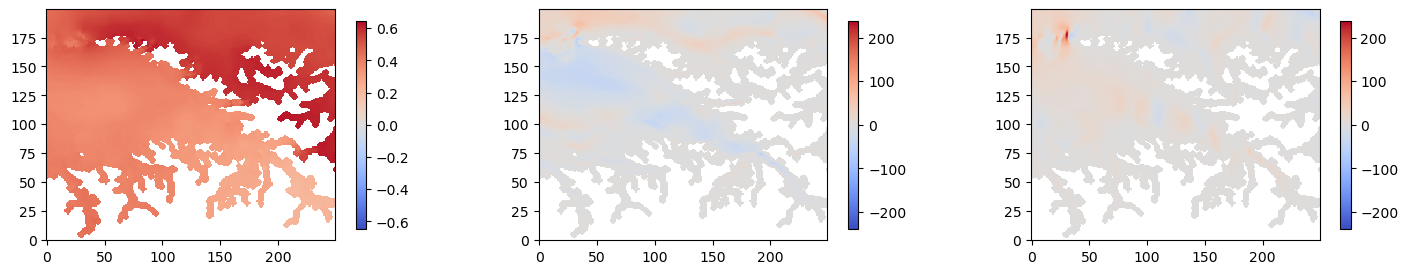

In [6]:
plot_state_da(data_args0[0])
plot_state_da(data_args0[1])
plot_state_da(data_args0[2])

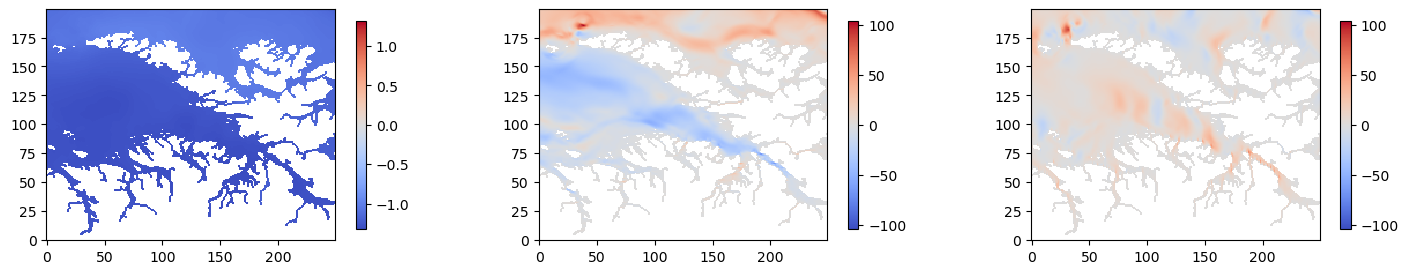

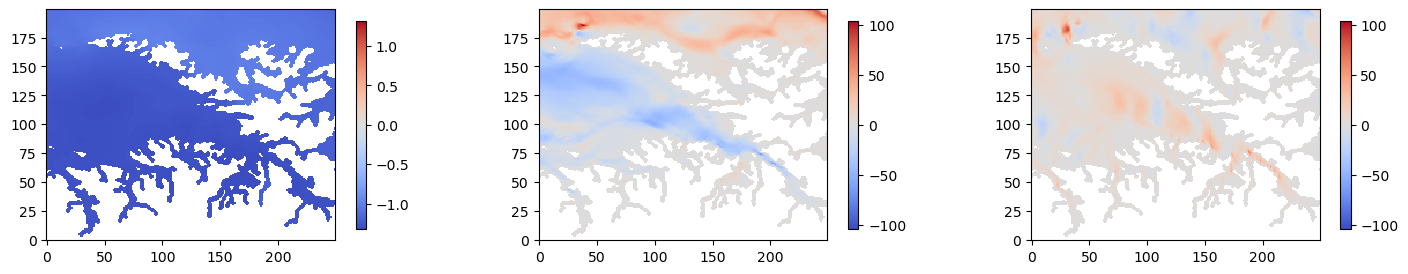

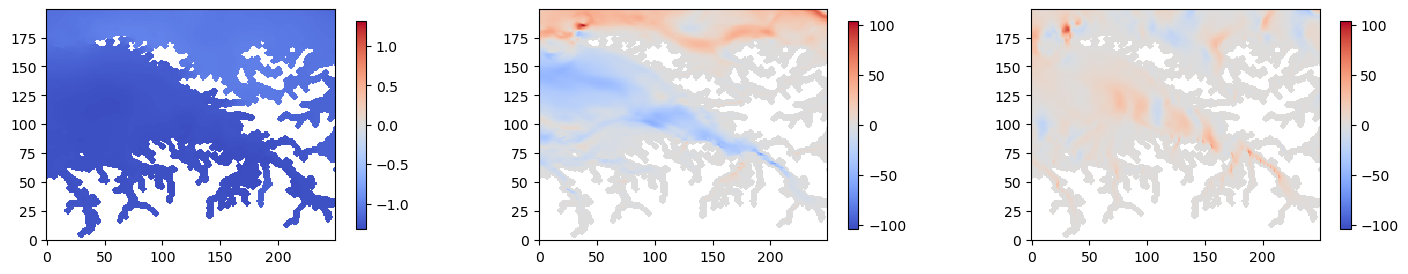

In [7]:
plot_state_da(data_args5[0])
plot_state_da(data_args5[1])
plot_state_da(data_args5[2])

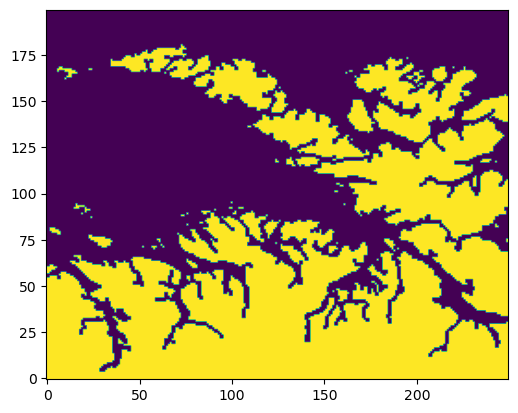

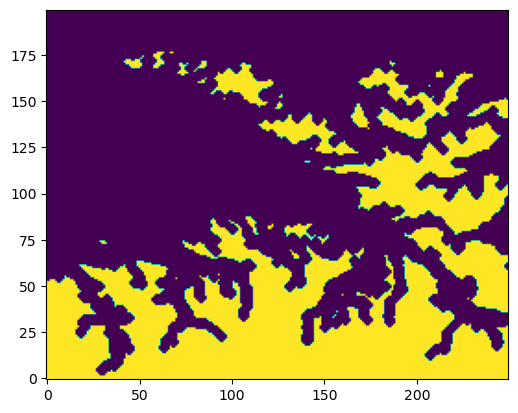

In [8]:
plt.imshow(data_args0[0]["eta0"].mask, origin="lower")
plt.figure()
plt.imshow(data_args5[2]["eta0"].mask, origin="lower")

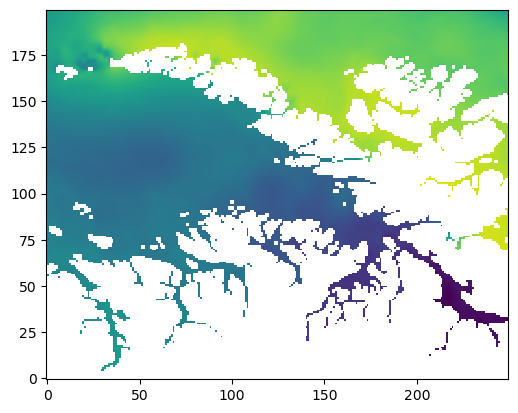

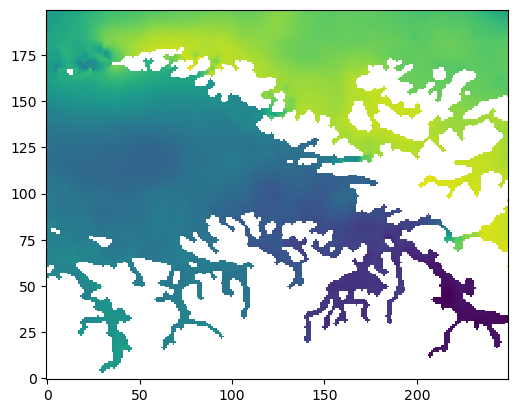

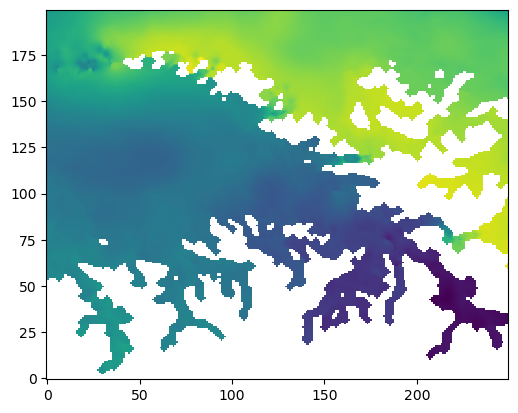

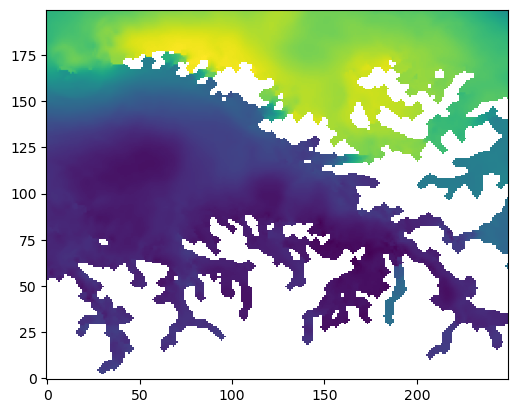

In [9]:
plt.imshow(data_args0[0]["eta0"], origin="lower")
plt.figure()
plt.imshow(data_args0[1]["eta0"], origin="lower")
plt.figure()
plt.imshow(data_args0[2]["eta0"], origin="lower")
plt.figure()
plt.imshow(data_args5[2]["eta0"], origin="lower")

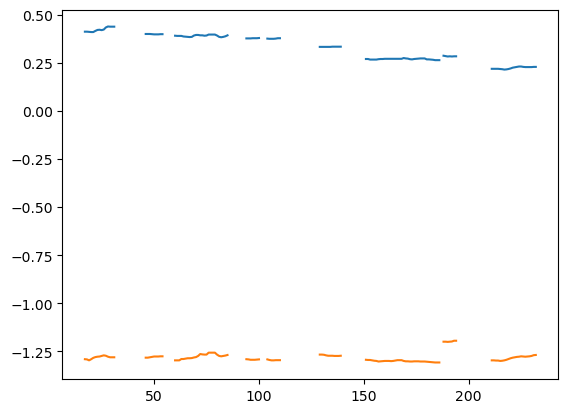

In [10]:
plt.plot(data_args0[2]["eta0"][50,:])
plt.plot(data_args5[2]["eta0"][50,:])

In [11]:
N = 6
data_args = [None]*N

for i in range(N):   
    timestep_indices = [[i, i+1]]
    if i == N-1:
        timestep_indices = [[i]]
    data_args[i] = NetCDFInitialization.getInitialConditions(source_url,
                                                        case_info["x0"], case_info["x1"], case_info["y0"], case_info["y1"], 
                                                        timestep_indices=timestep_indices,
                                                        download_data=False,
                                                        erode_land=2
                                                        )

Text(0.5, 1.0, 'eta0')

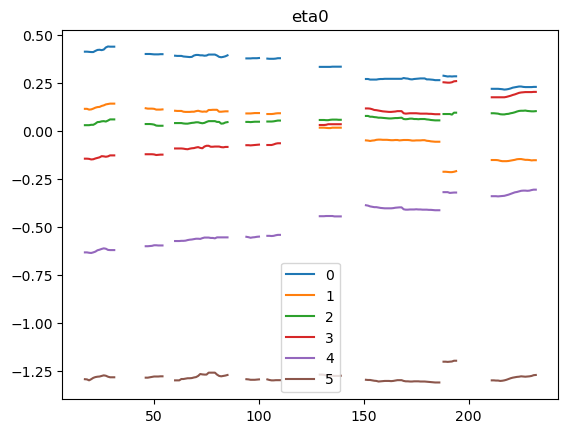

In [12]:
for i in range(N):
    plt.plot(data_args[i]["eta0"][50,:], label=str(i))
plt.legend()
plt.title('eta0')


Text(0.5, 1.0, 'hv0')

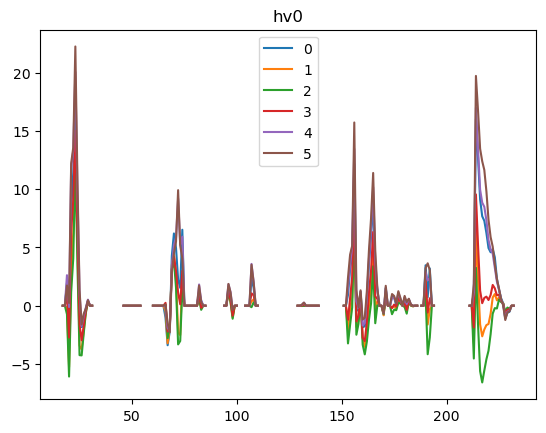

In [13]:
for i in range(N):
    plt.plot(data_args[i]["hv0"][50,:], label=str(i))
plt.legend()
plt.title('hv0')


In [14]:
def get_data_for_erosion(source_url, case_info, timestep_indices):
    source_url = NetCDFInitialization.checkCachedNetCDF(source_url)
    x0, x1, y0, y1 = case_info["x0"], case_info["x1"], case_info["y0"], case_info["y1"]
    init_t_index = timestep_indices[0]
    
    try:
        ncfile = Dataset(source_url)
        H_m = ncfile.variables['h'][y0-1:y1+1, x0-1:x1+1]
        eta0 = ncfile.variables['zeta'][init_t_index, y0-1:y1+1, x0-1:x1+1]
    except Exception as e:
        raise e
    finally:
        ncfile.close()

    H_m_mask = eta0.mask.copy()
    H_m = np.ma.array(H_m, mask=H_m_mask)
    return H_m, eta0
    
H_m, eta0 = get_data_for_erosion(source_url, case_info, timestep_indices5)                                            

Text(0.5, 1.0, 'eta0')

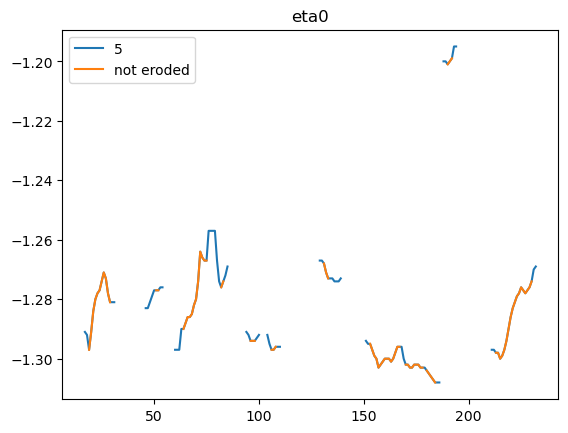

In [15]:
from scipy.ndimage.morphology import binary_erosion, grey_dilation
plt.plot(data_args[5]["eta0"][50,:], label=str(i))
plt.plot(eta0[51,1:-1], label="not eroded")

plt.legend()
plt.title('eta0')

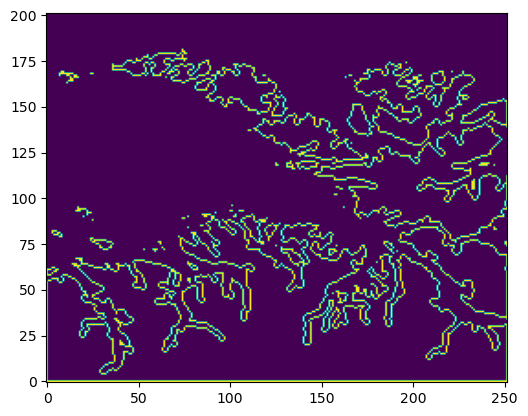

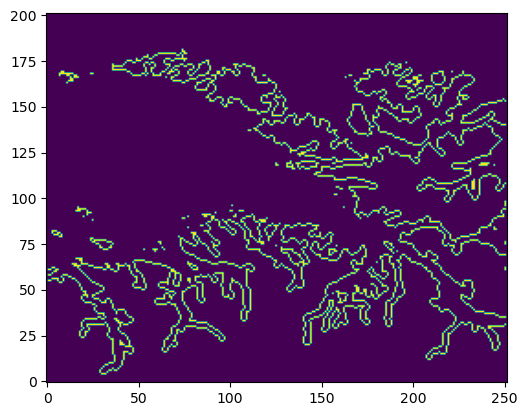

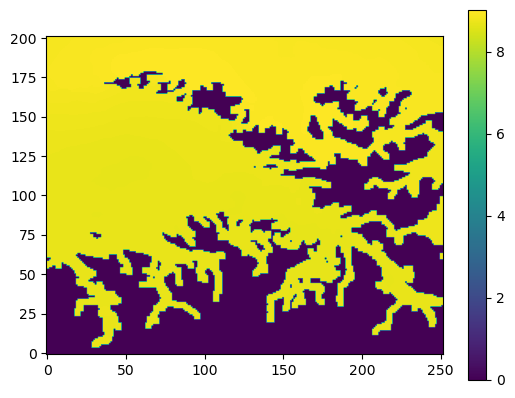

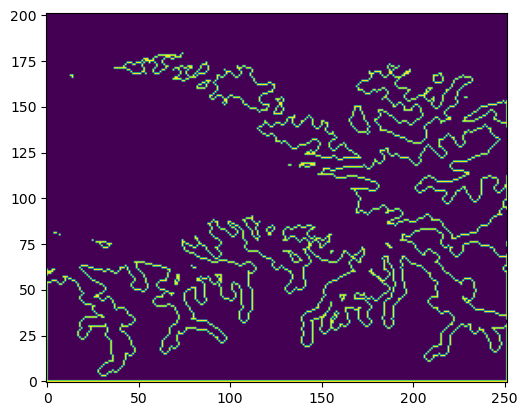

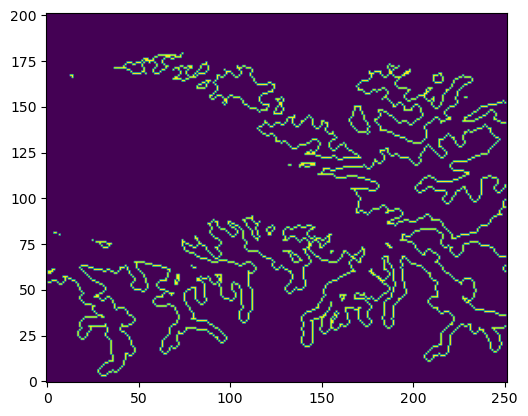

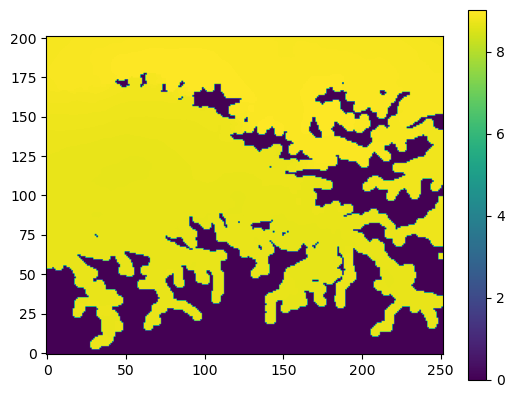

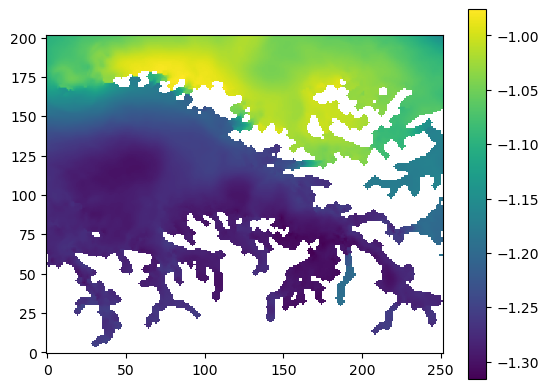

In [16]:
# First iteration of erosion
H_m, eta0 = get_data_for_erosion(source_url, case_info, timestep_indices5)

# Find all cells that should be wet that were not wet before
new_water = H_m.mask ^ binary_erosion(H_m.mask)
plt.figure(); plt.imshow(new_water, origin='lower')
new_water[0,:]  = False
new_water[-1,:] = False
new_water[:,0]  = False
new_water[:,-1] = False
plt.figure(); plt.imshow(new_water, origin='lower')


eta_tmp = eta0 + 10

eta0_dil = grey_dilation(eta_tmp.filled(0.0), size=(3,3))
plt.figure(); plt.imshow(eta0_dil, origin='lower')
plt.colorbar()

eta0_1 = eta0.copy()
eta0_1[new_water] = eta0_dil[new_water] - 10
H_m[new_water] = 5.00005

new_water = H_m.mask ^ binary_erosion(H_m.mask)
plt.figure(); plt.imshow(new_water, origin='lower')
new_water[0,:]  = False
new_water[-1,:] = False
new_water[:,0]  = False
new_water[:,-1] = False
plt.figure(); plt.imshow(new_water, origin='lower')

eta_tmp = eta0_1 + 10

eta0_dil = grey_dilation(eta_tmp.filled(0.0), size=(3,3))
plt.figure(); plt.imshow(eta0_dil, origin='lower')
plt.colorbar()

eta0_1[new_water] = eta0_dil[new_water] - 10
H_m[new_water] = 5.00005



#eta0_1[0,:] = eta0[0,:]
#eta0_1[-1,:] = eta0[-1,:]
#eta0_1[:,0] = eta0[:,0]
#eta0_1[:,-1] = eta0[:,-1]
plt.figure(); plt.imshow(eta0_1, origin='lower')
plt.colorbar()

Text(0.5, 1.0, 'eta0')

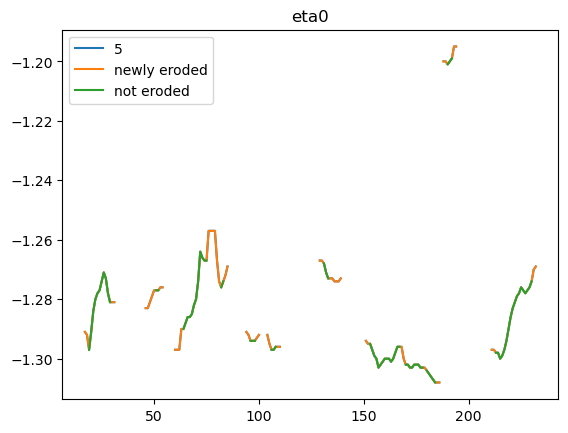

In [17]:
from scipy.ndimage.morphology import binary_erosion, grey_dilation
plt.plot(data_args[5]["eta0"][50,:], label=str(i))
plt.plot(eta0_1[51,1:-1], label="newly eroded")
plt.plot(eta0[51,1:-1], label="not eroded")

plt.legend()
plt.title('eta0')

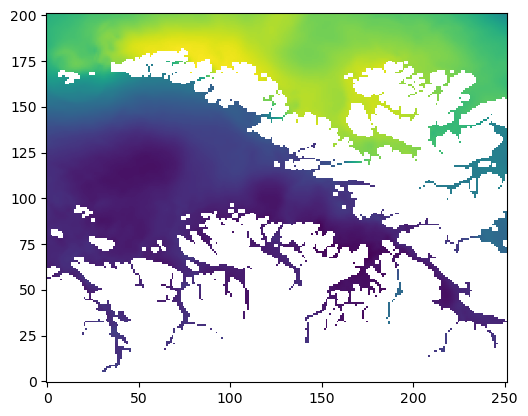

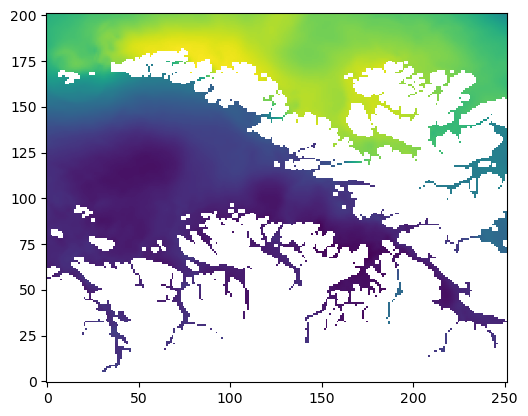

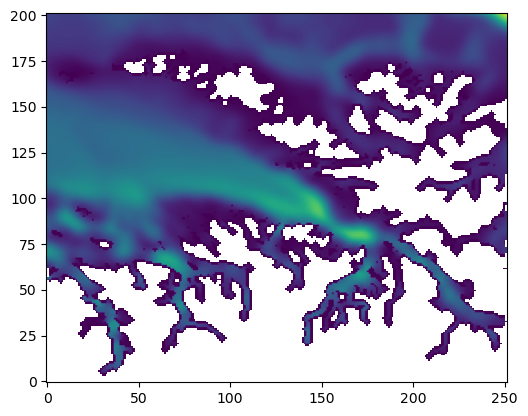

In [18]:
plt.imshow(eta0, origin="lower")
eta0_1 = eta0.copy()
plt.figure()
plt.imshow(eta0_1, origin="lower")
plt.figure()
plt.imshow(H_m, origin="lower")

In [19]:
a = np.zeros((7,7), dtype=int)
#a[2:5, 2:5] = -1
a[4,4] = 2
a[2,3] = 4
a[3,3] = 3
a

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 4, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

In [20]:
grey_dilation(a, size=(3,3))

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 4, 4, 4, 0, 0],
       [0, 0, 4, 4, 4, 0, 0],
       [0, 0, 4, 4, 4, 2, 0],
       [0, 0, 3, 3, 3, 2, 0],
       [0, 0, 0, 2, 2, 2, 0],
       [0, 0, 0, 0, 0, 0, 0]])

In [21]:
new_water

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])